Note: I've got the .dll/.pyd files in this directory. They're proprietary, so they're git ignored.


In [1]:
import pyvolution as mv
import sys
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

try:
    
    tif_file = "./tifs/total_psf.tif"
    tif_array = io.imread(tif_file)
    print(tif_array.shape)
    
    ## Initialize for later
    decon_array = np.random.random_sample(tif_array.shape)
    
    ##### Microvolution #####
    lic = mv.Licensing.GetInstance()
    lic_path = "C:\Misc programs\Fiji.app\plugins\MicroVolution\microvolution.lic"
    lic.SetPath(lic_path)
    
    ### Make Decon Params ###
    ## params = mv.DeconParameters() if you aren't doing LLS
    
    params = mv.LightSheetParameters()
    params.nx = tif_array.shape[1]
    params.ny = tif_array.shape[2]
    params.nz = tif_array.shape[0]
    params.iterations = 10
    params.wavelength = 488 # wavelength is lambda in C++/Java/C#
    params.dr = 104
    params.dz = 100
    params.NA = 1.1
    params.lightSheetNA = 0.7
    params.RI = 1.33
    params.ns = 1.33
    params.psfType = mv.PSFType.Widefield
    params.psfModel = mv.PSFModel.Vectorial
    params.generatePsf = True
    params.scaling = mv.Scaling.U16
    params.blind = True

    ### End Decon Params ####
    
    launcher = mv.DeconvolutionLauncher()
    launcher.SetParameters(params);
    
    ## Copy image to launcher from pointer, slice by slice
    for i in range(params.nz):
        launcher.SetImageSlice(i, tif_array[i])
    
    launcher.Run()
    
    ## Grab decon'd images from launcher to destination pointer
    for i in range(params.nz):
        launcher.RetrieveImageSlice(i, decon_array[i])
        
    launcher.Reset()
    #print("made to end")
except:
    print("Error:", sys.exc_info())

(101, 128, 128)


In [2]:
launcher.Reset()

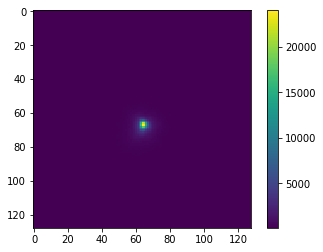

In [2]:

raw_MIP_array = np.amax(tif_array, axis=0)

plt.imshow(raw_MIP_array)
plt.colorbar()

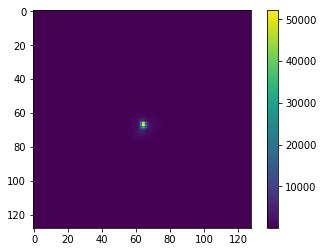

In [3]:
decon_MIP_array = np.amax(decon_array, axis=0)

plt.imshow(decon_MIP_array)
plt.colorbar()

In [4]:
def get_balanced_vmin_and_vmax(ratio_array):
    """return a vmin and vmax equally far from 1.0"""
    
    ## Determine how far away from baseline these values are
    min_diff = round(1 - ratio_array.min(), 2)
    max_diff = round(ratio_array.max() - 1, 2)
    
    ## Determine which to keep as deviation from baseline
    even_diff = max(min_diff, max_diff)
    
    vmin = round(1 - even_diff, 2)
    vmax = round(1 + even_diff, 2)
    
    return vmin, vmax

def side_by_side_plot(A_array, B_array, titleA, titleB):
    """Creates a 2x2 figure of A, B, A/B, A/B's histogram"""
    ratio_array = A_array / B_array
    
    ## max_of_AB ensures the colorbar will have same bounds
    max_of_AB = max(A_array.max(),B_array.max())
    
    (vmin, vmax) = get_balanced_vmin_and_vmax(ratio_array)
    
    #### Begin plotting
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(7,7))
    
    ### A_array
    axes[0, 0].set_title(titleA)
    A_im = axes[0, 0].imshow(A_array,
                             vmax=max_of_AB,
                      #norm = colors.LogNorm(vmin=50, vmax=max_of_AB)
                     )
    axes[0,0].axis('off')
    divider = make_axes_locatable(axes[0,0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(A_im, cax=cax)
    
    ### B_array
    axes[0,1].set_title(titleB)
    B_im = axes[0,1].imshow(B_array,
                            vmax=max_of_AB,
                    #norm = colors.LogNorm(vmin=50, vmax=max_of_AB)
                    )
    axes[0,1].axis('off')
    divider = make_axes_locatable(axes[0,1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(B_im, cax=cax)
    
    
    ### Ratio
    axes[1,0].set_title('ratio: top-left / top-right')
    R_im = axes[1,0].imshow(ratio_array,
                     cmap="coolwarm",
                     vmin=vmin,
                     vmax=vmax,
                    )
    axes[1,0].axis('off')
    divider = make_axes_locatable(axes[1,0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(R_im, cax=cax)
    
    axes[1,1].hist(ratio_array.flatten(), bins=30)
    axes[1,1].set_title("Ratio pixels")
    fig.tight_layout()

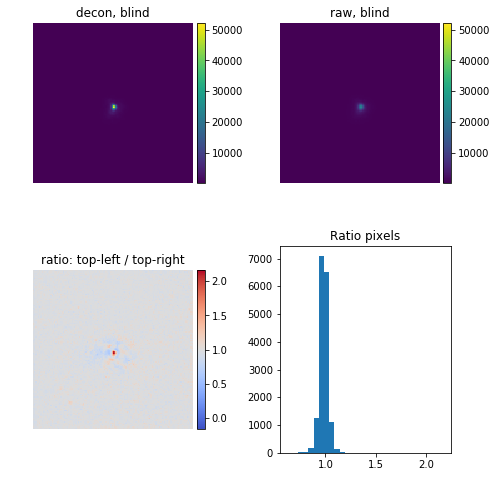

In [5]:
side_by_side_plot(decon_MIP_array,
                  raw_MIP_array,
                  "decon, blind",
                  "raw, blind",
                 )